**Aim**:
Construct a reservoir that can learn to predict future letters of text by reading it 1 symbol at a time

**Output**:
Must output probability distribution of a future letter

**Metric**: (How to determine performance)
Compute true NDim empirical distribution. For each output, compute difference between true and predicted distributions $||p_{true} - \hat{p}||_2$

**Status**:
* Reservoir seems in a stable input-driven state. However, I suspect it is in chaotic overdrive due to somewhat oscillatory nature
* Output achieves correct magnitude, but not correct distribution. Possibly chaotic nature does not allow for memory
* Output plasticity seems to have an upwards drift somewhat typical of a numerical instability. No clue why.
* Inhibition is really bad. Due to single timestep delay of EXC->INH->EXC path vs EXC->EXC path, there is immediately an oscillatory behaviour of period of 2 steps.

**TODO**:
* Lookup how memory of such networks is computed, see if we can extend
* Lookup how people get non-chaotic behaviour from ECHO, seems like most of phase-space is chaotic.
* Consider slow rate-based inhibition.
* Consider semi-discrete reservoir, maybe even rate-based.
* Add IP to ensure varied neuronal response
* Study numerical instability. Have a look at higher order terms of STDP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


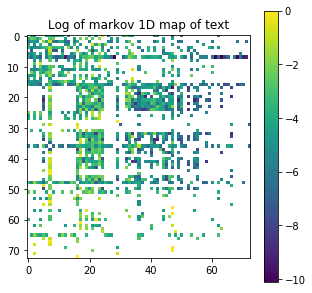

In [3]:
# Figure out what characters exist, and what is their true distribution
with open('/home/aleksejs/Downloads/aliceW.txt') as f:
    text = f.read()
    
ch2freq = {}
for ch in text:
    if ch in ch2freq.keys():
        ch2freq[ch] += 1
    else:
        ch2freq[ch] = 1

# Count existing characters and enumerate them consecutively
N_TEXT = len(text)
N_CHAR = len(ch2freq)
char2drint = {ch : i for i, ch in enumerate(ch2freq.keys())}

# # True distribution of markov order 1
markov1 = np.zeros((N_CHAR, N_CHAR))
for i in range(1, N_TEXT):
    idx_1 = char2drint[text[i-1]]
    idx_2 = char2drint[text[i]]
    markov1[idx_1][idx_2] += 1

for i in range(N_CHAR):
    markov1[i] /= np.sum(markov1[i])

plt.figure(figsize=(5,5))
plt.title("Log of markov 1D map of text")
plt.imshow(np.log(markov1))
plt.colorbar()
plt.show()

# Convert character to reduced numpy array
def char2np(ch):
    rez = np.zeros(N_CHAR, dtype=int)
    rez[char2drint[ch]] = 1
    return rez

In [3]:
pd.DataFrame({v: k for k, v in char2drint.items()}, index=["char"])

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
char,A,L,I,C,E,’,S,,D,V,...,z,[,“,”,*,_,Q,J,X,]


In [24]:
def nonlin(X, TH):
    X[X < TH] = 0
    X[X >= TH] = 1
    return X

# def out2prob(X):
# # Normalization-based
#     return X / np.sum(X)
# # Softmax-based
# #     e = np.exp(X)
# #     return e / np.sum(e)
    
def output_plasticity(W, XPRE, XPOST, XTRUE, zeta, withNeg=True):
    Wnew =  W - zeta * np.outer(XPOST - XTRUE, XPRE)
    if not withNeg:
        Wnew[Wnew < 0] = 0
    return Wnew

def Lerr(ch_pre, p_post):
    p_true = markov1[char2drint[ch_pre]]
    return np.linalg.norm(p_true - p_post)

def normmat(W):
    return W * (W.shape[1] / np.sum(W))

**Trivial model V1:** Learn mapping from this character to itself

**Result**: Learning on average happens well, but rarely occuring characters do not manage to converge over the time course of the book

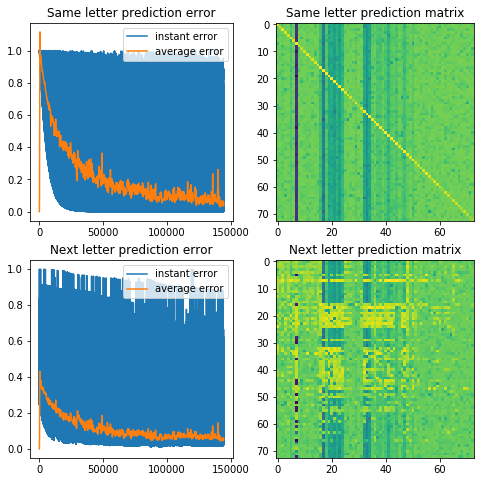

In [22]:
N_INP = N_CHAR
N_OUT_THIS = N_CHAR
N_OUT_NEXT = N_CHAR
M_IO_THIS = np.random.uniform(0, 1, (N_OUT_THIS, N_INP))
M_IO_NEXT = np.random.uniform(0, 1, (N_OUT_NEXT, N_INP))
M_IO_THIS /= np.sum(M_IO_THIS)
M_IO_NEXT /= np.sum(M_IO_NEXT)

err_hist_this = np.zeros(N_TEXT-1)
err_hist_next = np.zeros(N_TEXT-1)
for i in range(1, N_TEXT):
    X_INP = char2np(text[i-1])
    X_OUT_THIS = M_IO_THIS.dot(X_INP)
    X_OUT_NEXT = M_IO_NEXT.dot(X_INP)
    X_OUT_THIS_TRUE = char2np(text[i-1])
    X_OUT_NEXT_TRUE = char2np(text[i])
    M_IO_THIS = output_plasticity(M_IO_THIS, X_INP, X_OUT_THIS, X_OUT_THIS_TRUE, 0.001)
    M_IO_NEXT = output_plasticity(M_IO_NEXT, X_INP, X_OUT_NEXT, X_OUT_NEXT_TRUE, 0.001)
    err_hist_this[i-1] = np.linalg.norm(X_OUT_THIS - X_OUT_THIS_TRUE)
    err_hist_next[i-1] = Lerr(text[i-1], X_OUT_NEXT)
    
# Compute smooth average running error
err_lpf_this = butter_lowpass_filter(err_hist_this, 2, 1000, order=5)
err_lpf_next = butter_lowpass_filter(err_hist_next, 2, 1000, order=5)
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0][0].plot(err_hist_this, label='instant error')
ax[0][0].plot(err_lpf_this,  label='average error')
ax[0][0].legend()
ax[0][1].imshow(np.log(M_IO_THIS))
ax[1][0].plot(err_hist_next, label='instant error')
ax[1][0].plot(err_lpf_next,  label='average error')
ax[1][0].legend()
ax[1][1].imshow(np.log(M_IO_NEXT))
ax[0][0].set_title("Same letter prediction error")
ax[0][1].set_title("Same letter prediction matrix")
ax[1][0].set_title("Next letter prediction error")
ax[1][1].set_title("Next letter prediction matrix")
plt.show()

**Trivial model V2:** Learn mapping from character to itself, but via a compressed random layer

**Result**: Works as good for $N_{HID} \geq N_{INP}$, and progressively gets worse for $N_{HID} < N_{INP}$

* Does not work if we forbid decoding weights to be negative

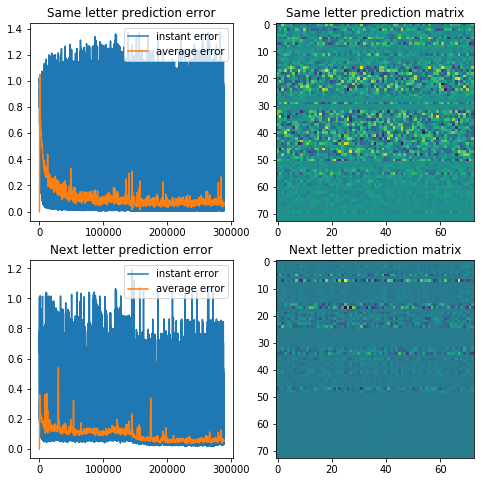

In [37]:
N_INP = N_CHAR
N_HID = N_CHAR
N_OUT_THIS = N_CHAR
N_OUT_NEXT = N_CHAR
M_IH      = normmat(np.random.uniform(0, 1, (N_HID, N_INP)))
M_HO_THIS = normmat(np.random.uniform(0, 1, (N_OUT_THIS, N_HID)))
M_HO_NEXT = normmat(np.random.uniform(0, 1, (N_OUT_NEXT, N_HID)))

N_REP = 2
N_STEP = N_TEXT
err_hist_this = np.zeros(N_REP*(N_STEP-1))
err_hist_next = np.zeros(N_REP*(N_STEP-1))
for irep in range(N_REP):
    for i in range(1, N_STEP):
        X_INP = char2np(text[i-1])
        X_HID = M_IH.dot(X_INP)
        X_OUT_THIS = M_HO_THIS.dot(X_HID)
        X_OUT_NEXT = M_HO_NEXT.dot(X_HID)
        X_OUT_THIS_TRUE = char2np(text[i-1])
        X_OUT_NEXT_TRUE = char2np(text[i])
        M_HO_THIS = output_plasticity(M_HO_THIS, X_HID, X_OUT_THIS, X_OUT_THIS_TRUE, 1.0 / 10**irep)
        M_HO_NEXT = output_plasticity(M_HO_NEXT, X_HID, X_OUT_NEXT, X_OUT_NEXT_TRUE, 1.0 / 10**irep)
        err_hist_this[i-1 + irep*(N_STEP-1)] = np.linalg.norm(X_OUT_THIS - X_OUT_THIS_TRUE)
        err_hist_next[i-1 + irep*(N_STEP-1)] = Lerr(text[i-1], X_OUT_NEXT)
    
# Compute smooth average running error
err_lpf_this = butter_lowpass_filter(err_hist_this, 2, 1000, order=5)
err_lpf_next = butter_lowpass_filter(err_hist_next, 2, 1000, order=5)
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0][0].plot(err_hist_this, label='instant error')
ax[0][0].plot(err_lpf_this,  label='average error')
ax[0][0].legend()
ax[0][1].imshow(M_HO_THIS)
ax[1][0].plot(err_hist_next, label='instant error')
ax[1][0].plot(err_lpf_next,  label='average error')
ax[1][0].legend()
ax[1][1].imshow(M_HO_NEXT)
ax[0][0].set_title("Same letter prediction error")
ax[0][1].set_title("Same letter prediction matrix")
ax[1][0].set_title("Next letter prediction error")
ax[1][1].set_title("Next letter prediction matrix")
plt.show()

**Trivial Model V3**: Use reservoir to learn mapping. Fit output using $L2$ norm, like pure machine learning

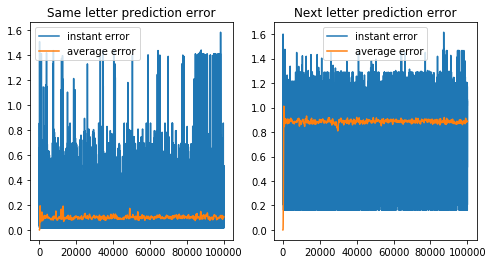

In [51]:
# Dimensions
N_INP = N_CHAR
N_REZ_EXC = 100
N_REZ_INH = 100
N_OUT = N_CHAR

# Reservoir
INP_MAG = 0.7 * N_REZ_EXC
W_MAG_EE = 0.5
W_MAG_EI = 2.0
W_MAG_IE = 0.5
W_MAG_EO = 1.0
TH_EXC = 1
TH_INH = 1.3

# Matrices
M_INP_EXC = INP_MAG  * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_INP)))
M_EXC_EXC = W_MAG_EE * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_REZ_EXC)))
M_EXC_INH = W_MAG_EI * normmat(np.random.uniform(0, 1, (N_REZ_INH, N_REZ_EXC)))
M_INH_EXC = W_MAG_IE * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_REZ_INH)))

# Vectors
X_EXC = np.random.randint(0, 2, N_REZ_EXC)
X_INH = np.random.randint(0, 2, N_REZ_INH)

N_STEP = 50000#N_TEXT

x_exc_lst = []
out_this_lst = [char2np(t) for t in text[:N_STEP-1]]
out_next_lst = [char2np(t) for t in text[1:N_STEP]]

for i in range(1, N_STEP):
    X_INP = char2np(text[i-1])
    X_OUT_THIS_TRUE = char2np(text[i-1])
    X_OUT_NEXT_TRUE = char2np(text[i])
    
    # Propagate signals
    X_INP_EXC = M_INP_EXC.dot(X_INP)
    X_EXC_EXC = M_EXC_EXC.dot(X_EXC)
    X_EXC_INH = M_EXC_INH.dot(X_EXC)
    X_INH_EXC = M_INH_EXC.dot(X_INH)
    
    # Update populations
    X_EXC = nonlin(X_INP_EXC + X_EXC_EXC - X_INH_EXC, TH_EXC)
    X_INH = nonlin(X_EXC_INH, TH_INH)
    
    # Store result
    x_exc_lst += [X_EXC]
    
# Linear Fit
def fit(Xlst, Ylst):
    XX = np.sum([np.outer(x,x) for x in Xlst], axis=0)
    YX = np.sum([np.outer(y,x) for x,y in zip(Xlst, Ylst)], axis=0)
    return YX.dot(np.linalg.inv(XX))

Wthis = fit(x_exc_lst, out_this_lst)
Wnext = fit(x_exc_lst, out_next_lst)


# Now model

N_STEP = 100000#N_TEXT

err_hist_this = []
err_hist_next = []
for i in range(1, N_STEP):
    X_INP = char2np(text[i-1])
    X_OUT_THIS_TRUE = char2np(text[i-1])
    X_OUT_NEXT_TRUE = char2np(text[i])
    
    # Propagate signals
    X_INP_EXC = M_INP_EXC.dot(X_INP)
    X_EXC_EXC = M_EXC_EXC.dot(X_EXC)
    X_EXC_INH = M_EXC_INH.dot(X_EXC)
    X_INH_EXC = M_INH_EXC.dot(X_INH)
    
    # Update populations
    X_EXC = nonlin(X_INP_EXC + X_EXC_EXC - X_INH_EXC, TH_EXC)
    X_INH = nonlin(X_EXC_INH, TH_INH)
    
    # Store result
    X_OUT_THIS = Wthis.dot(X_EXC)
    X_OUT_NEXT = Wnext.dot(X_EXC)
    
    err_hist_this += [np.linalg.norm(X_OUT_THIS - X_OUT_THIS_TRUE)]
    err_hist_next += [np.linalg.norm(X_OUT_NEXT - X_OUT_NEXT_TRUE)]
    
# Compute smooth average running error
err_lpf_this = butter_lowpass_filter(err_hist_this, 2, 1000, order=5)
err_lpf_next = butter_lowpass_filter(err_hist_next, 2, 1000, order=5)
    
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].plot(err_hist_this, label='instant error')
ax[0].plot(err_lpf_this,  label='average error')
ax[0].legend()
ax[1].plot(err_hist_next, label='instant error')
ax[1].plot(err_lpf_next,  label='average error')
ax[1].legend()
ax[0].set_title("Same letter prediction error")
ax[1].set_title("Next letter prediction error")
plt.show()

**Trivial model V4**: Same as above, but using Hebb

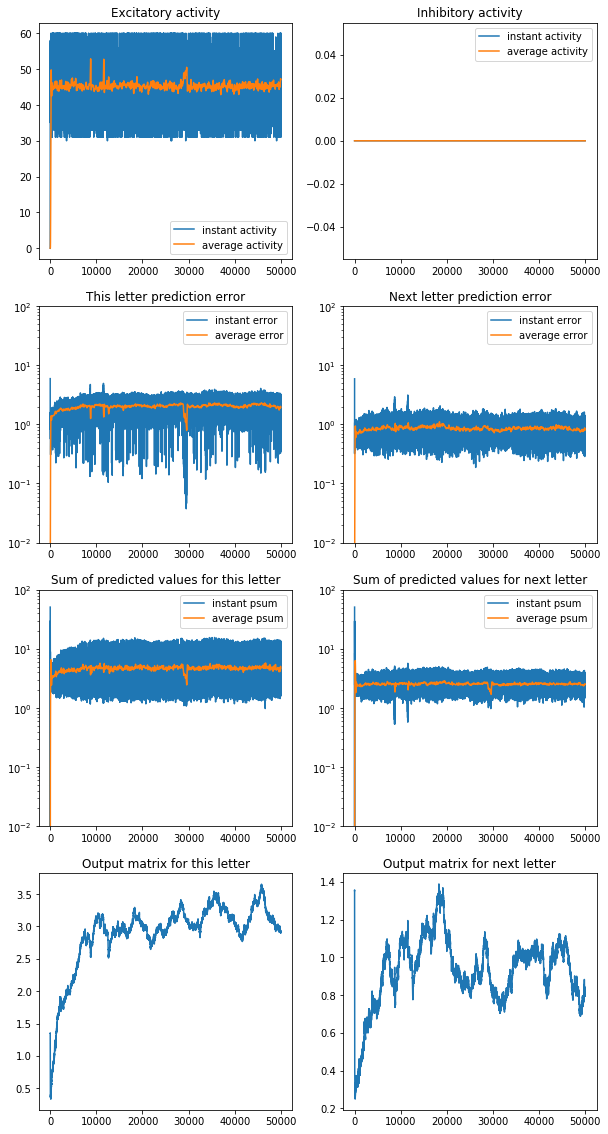

In [45]:
# Dimensions
N_INP = N_CHAR
N_REZ_EXC = 100
N_REZ_INH = 100
N_OUT = N_CHAR

# Constants
PLAST_ZETA_OUT = 0.01
W_MAG_EE = 0.5
W_MAG_EI = 0.0
W_MAG_IE = 3.0
W_MAG_EO = 1.0
TH_EXC = 1
TH_INH = 1
INP_MAG = 0.7 * N_REZ_EXC

# Matrices
M_INP_EXC = INP_MAG  * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_INP)))
M_EXC_EXC = W_MAG_EE * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_REZ_EXC)))
M_EXC_INH = W_MAG_EI * normmat(np.random.uniform(0, 1, (N_REZ_INH, N_REZ_EXC)))
M_INH_EXC = W_MAG_IE * normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_REZ_INH)))
M_EXC_OUT_THIS = W_MAG_EO * normmat(np.random.uniform(0, 1, (N_OUT, N_REZ_EXC)))
M_EXC_OUT_NEXT = W_MAG_EO * normmat(np.random.uniform(0, 1, (N_OUT, N_REZ_EXC)))

# Vectors
X_EXC = np.random.randint(0, 2, N_REZ_EXC)
X_INH = np.random.randint(0, 2, N_REZ_INH)

N_STEP = 50000#N_TEXT
err_hist_this = np.zeros(N_STEP-1)
err_hist_next = np.zeros(N_STEP-1)
x_exc_hist = np.zeros(N_STEP-1)
x_inh_hist = np.zeros(N_STEP-1)
x_out_this_hist = np.zeros(N_STEP-1)
x_out_next_hist = np.zeros(N_STEP-1)
w_out_this_hist = np.zeros(N_STEP-1)
w_out_next_hist = np.zeros(N_STEP-1)

for i in range(1, N_STEP):
    X_INP = char2np(text[i-1])
    X_OUT_THIS_TRUE = char2np(text[i-1])
    X_OUT_NEXT_TRUE = char2np(text[i])
    
    # Propagate signals
    X_INP_EXC = M_INP_EXC.dot(X_INP)
    X_EXC_EXC = M_EXC_EXC.dot(X_EXC)
    X_EXC_INH = M_EXC_INH.dot(X_EXC)
    X_INH_EXC = M_INH_EXC.dot(X_INH)
    X_EXC_OUT_THIS = M_EXC_OUT_THIS.dot(X_EXC)
    X_EXC_OUT_NEXT = M_EXC_OUT_NEXT.dot(X_EXC)
    
    # Update populations
    X_EXC = nonlin(X_INP_EXC + X_EXC_EXC - X_INH_EXC, TH_EXC)
    X_INH = nonlin(X_EXC_INH, TH_INH)
    X_OUT_THIS = X_EXC_OUT_THIS #out2prob(X_EXC_OUT)
    X_OUT_NEXT = X_EXC_OUT_NEXT #out2prob(X_EXC_OUT)
#     if np.sum(X_OUT_THIS) > 0:
#         X_OUT_THIS /= np.sum(X_OUT_THIS)
#     if np.sum(X_OUT_NEXT) > 0:
#         X_OUT_NEXT /= np.sum(X_OUT_NEXT)
    
    # Plasticity
    M_EXC_OUT_THIS = output_plasticity(M_EXC_OUT_THIS, X_EXC, X_OUT_THIS, X_OUT_THIS_TRUE, PLAST_ZETA_OUT, False)
    M_EXC_OUT_NEXT = output_plasticity(M_EXC_OUT_NEXT, X_EXC, X_OUT_NEXT, X_OUT_NEXT_TRUE, PLAST_ZETA_OUT, False)
    
    # Record
    err_hist_this[i-1] = np.linalg.norm(X_OUT_THIS - X_OUT_THIS_TRUE)
    err_hist_next[i-1] = Lerr(text[i-1], X_OUT_NEXT)
    x_exc_hist[i-1] = np.sum(X_EXC)
    x_inh_hist[i-1] = np.sum(X_INH)
    x_out_this_hist[i-1] = np.sum(X_OUT_THIS)
    x_out_next_hist[i-1] = np.sum(X_OUT_NEXT)
    w_out_this_hist[i-1] = np.linalg.norm(M_EXC_OUT_THIS)
    w_out_next_hist[i-1] = np.linalg.norm(M_EXC_OUT_NEXT)

# Compute smooth average running error
x_exc_lpf = butter_lowpass_filter(x_exc_hist, 5, 1000, order=5)
x_inh_lpf = butter_lowpass_filter(x_inh_hist, 5, 1000, order=5)
err_lpf_this = butter_lowpass_filter(err_hist_this, 5, 1000, order=5)
err_lpf_next = butter_lowpass_filter(err_hist_next, 5, 1000, order=5)
x_out_lpf_this = butter_lowpass_filter(x_out_this_hist, 5, 1000, order=5)
x_out_lpf_next = butter_lowpass_filter(x_out_next_hist, 5, 1000, order=5)
    
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
ax[0][0].plot(x_exc_hist, label='instant activity')
ax[0][1].plot(x_inh_hist, label='instant activity')
ax[0][0].plot(x_exc_lpf, label='average activity')
ax[0][1].plot(x_inh_lpf, label='average activity')
ax[1][0].semilogy(err_hist_this, label='instant error')
ax[1][1].semilogy(err_hist_next, label='instant error')
ax[1][0].semilogy(err_lpf_this, label='average error')
ax[1][1].semilogy(err_lpf_next, label='average error')
ax[2][0].semilogy(x_out_this_hist, label='instant psum')
ax[2][1].semilogy(x_out_next_hist, label='instant psum')
ax[2][0].semilogy(x_out_lpf_this, label='average psum')
ax[2][1].semilogy(x_out_lpf_next, label='average psum')
ax[3][0].plot(w_out_this_hist)
ax[3][1].plot(w_out_next_hist)

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()
ax[2][0].legend()
ax[2][1].legend()
ax[1][0].set_ylim(1.0e-2, 1.0e+2)
ax[1][1].set_ylim(1.0e-2, 1.0e+2)
ax[2][0].set_ylim(1.0e-2, 1.0e+2)
ax[2][1].set_ylim(1.0e-2, 1.0e+2)

ax[0][0].set_title("Excitatory activity")
ax[0][1].set_title("Inhibitory activity")
ax[1][0].set_title("This letter prediction error")
ax[1][1].set_title("Next letter prediction error")
ax[2][0].set_title("Sum of predicted values for this letter")
ax[2][1].set_title("Sum of predicted values for next letter")
ax[3][0].set_title("Output matrix for this letter")
ax[3][1].set_title("Output matrix for next letter")
plt.show()

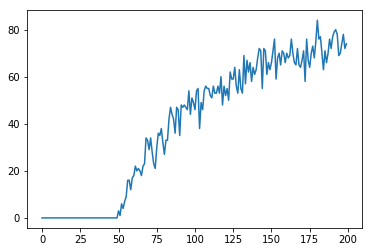

In [46]:
conv = []
for i in range(2*N_REZ_EXC):
    M = i*normmat(np.random.uniform(0, 1, (N_REZ_EXC, N_INP)))
    x = np.zeros(N_CHAR)
    x[0] = 1
    y = M.dot(x)
    conv += [np.sum(y >= 1)]

plt.figure()
plt.plot(conv)
plt.show()